In [90]:
#import essential modules

import os
import h5py #top open h5 binary files
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import cv2 
np.set_printoptions(suppress=True) #suppress sciebntific notations

In [91]:
filename = '/media/amr/Amr_4TB/plus_maze/Exp_2017_10_21_plus_maze_20171021_135915_264DeepCut_resnet50_Plus_MaizDec25shuffle1_10000.h5'

In [92]:
#create trajectory map
def draw_trajectory(filename): #needs one argument, the h5 file name or the video
    
    #get the file directory
    file_dir = os.path.dirname(filename)
    
    
    filename_without_ext = os.path.splitext(os.path.basename(filename))[0] #remove the extension
    
    #import the .h5 file and extract the x,y coordinates in each frame
    h5_file = h5_file = file_dir + '/' + filename_without_ext + '.h5' #you need the abs path to work properly
    f = h5py.File(h5_file, 'r')

    print("Keys: %s" % f.keys())

    #Get the keys from the file
    a_group_key = list(f.keys())[0]

    #convert the keys to a dataframe to make them easier to handle and to plot
    data = pd.read_hdf(h5_file, a_group_key)

    x = data.iloc[100:, 0][data.iloc[:,2]>0.7] #Remove the first 300 frames to compensate for confusion at the beginning
    y = data.iloc[100:, 1][data.iloc[:,2]>0.7]
    
    
    #create trajectory
    #you can control the outliers by modifying the likelihood value [data.iloc[:,2]>0.7]
    plt.figure(figsize=(4,4), dpi=300)
    plt.plot(x,y, color='k', linewidth=1)
    plt.axis('off')
    plt.gca().invert_yaxis() #otherwise the images appear mirror imaged
    plt.savefig('%s/%s_Trajectory.png' % (file_dir,filename_without_ext))
    
    

Keys: KeysView(<HDF5 file "Exp_2017_10_21_plus_maze_20171021_135915_264DeepCut_resnet50_Plus_MaizDec25shuffle1_10000.h5" (mode r)>)


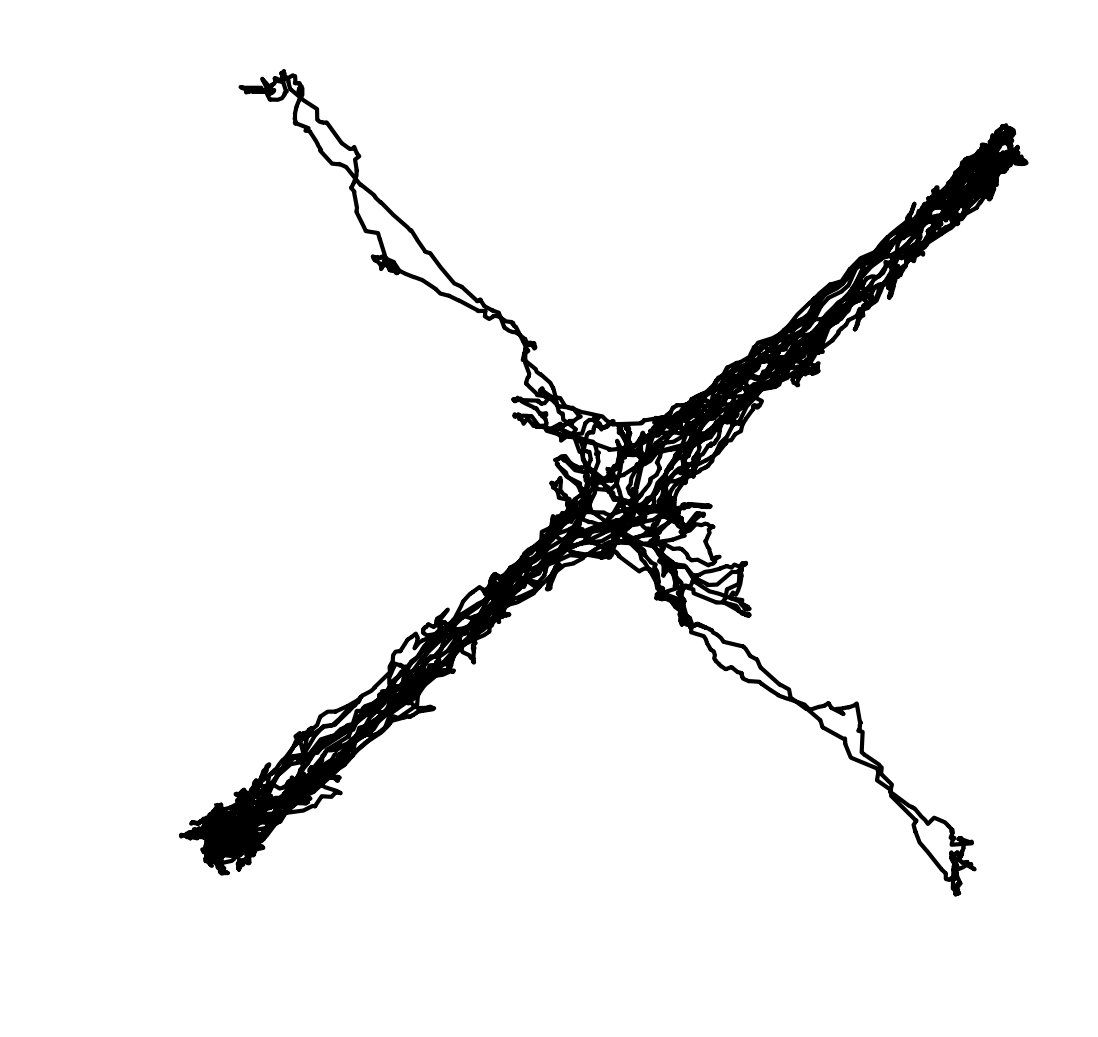

In [93]:
draw_trajectory(filename)

In [94]:
#Create density maps
def draw_density_map(filename):
    from scipy.stats import kde #kernel density estimate
    
    #get the file directory
    file_dir = os.path.dirname(filename)
    
    
    filename_without_ext = os.path.splitext(os.path.basename(filename))[0] #remove the extension
    
    #import the .h5 file and extract the x,y coordinates in each frame
    h5_file = h5_file = file_dir + '/' + filename_without_ext + '.h5' #you need the abs path to work properly
    f = h5py.File(h5_file, 'r')

    print("Keys: %s" % f.keys())

    #Get the keys from the file
    a_group_key = list(f.keys())[0]

    #convert the keys to a dataframe to make them easier to handle and to plot
    data = pd.read_hdf(h5_file, a_group_key)

    x = data.iloc[100:, 0][data.iloc[:,2]>0.7] #Remove the first 300 frames to compensate for confusion at the beginning
    y = data.iloc[100:, 1][data.iloc[:,2]>0.7]
     
    
    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    nbins=300 #300 is a very good compromise both computationally and aesthetically 
    k = kde.gaussian_kde([x,y])
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    plt.figure(figsize=(6,4), dpi=300)
    plt.pcolormesh(xi, yi, (zi.reshape(xi.shape) - zi.min())/(zi.max()), cmap='jet') #normalize zi value to get colorbar from 0-1
    plt.colorbar(ticks=[0,0.2,0.4,0.6,0.8,1])
    plt.axis('off')
    plt.gca().invert_yaxis()
    
    plt.savefig('%s/%s_Density.png' % (file_dir,filename_without_ext))
    

Keys: KeysView(<HDF5 file "Exp_2017_10_21_plus_maze_20171021_135915_264DeepCut_resnet50_Plus_MaizDec25shuffle1_10000.h5" (mode r)>)


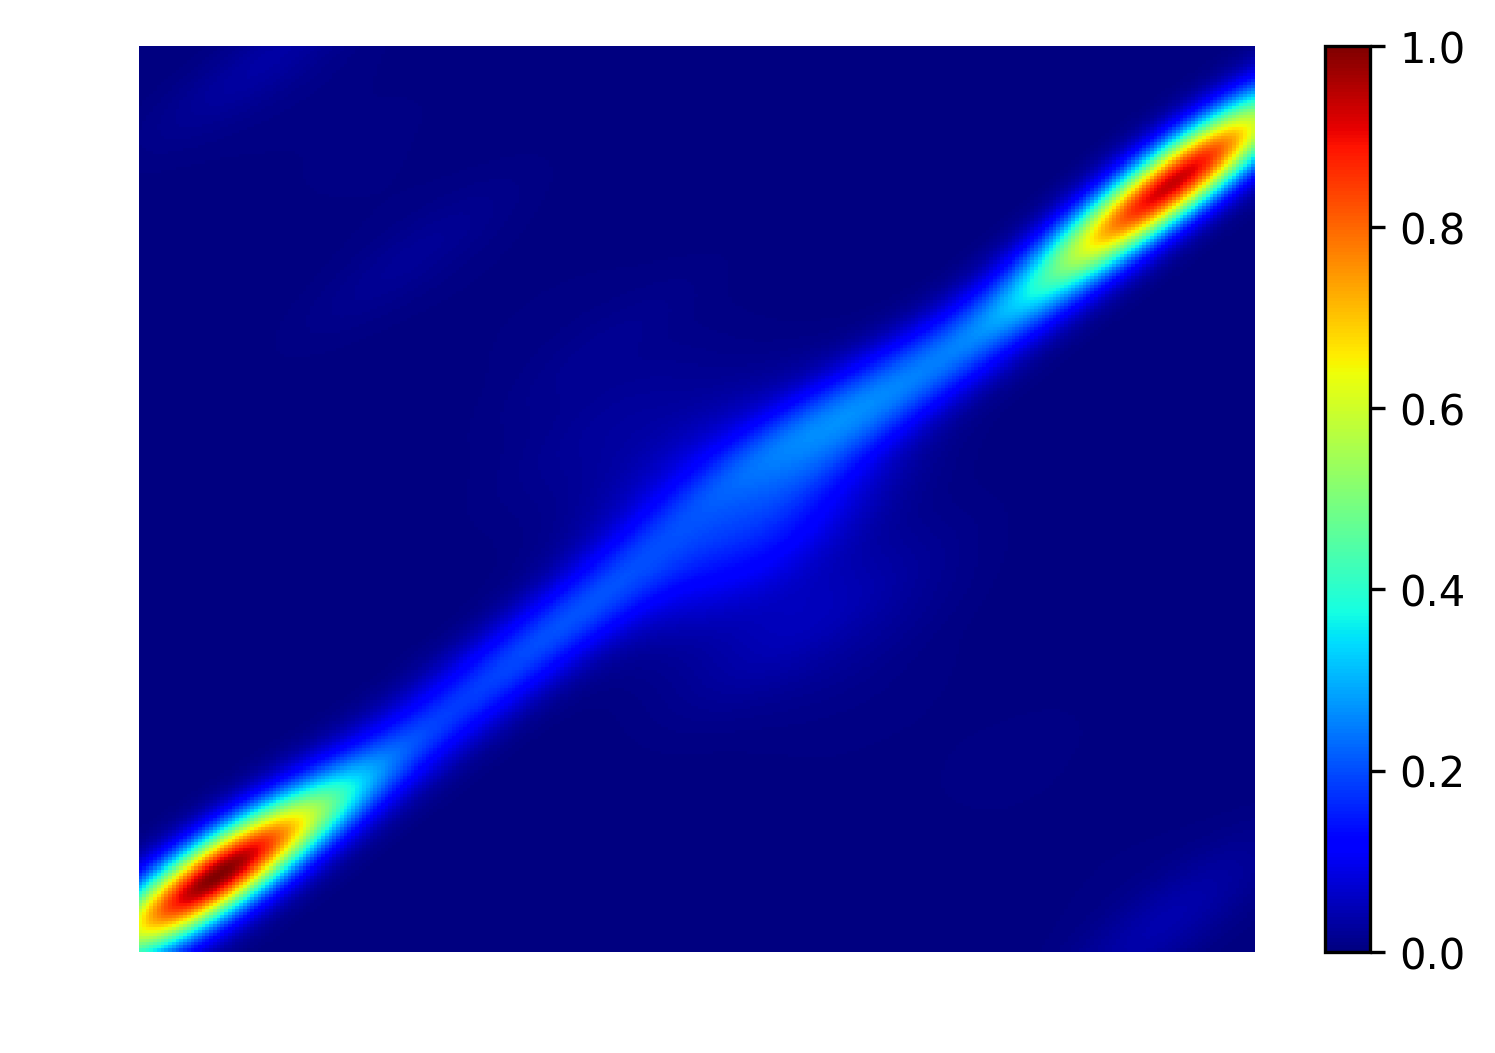

In [95]:
draw_density_map(filename)

In [96]:
#calculate the total distance traveled by the animal
def calculate_distance(filename):
    #get the file directory
    file_dir = os.path.dirname(filename)
    
    
    filename_without_ext = os.path.splitext(os.path.basename(filename))[0] #remove the extension
    
    #import the .h5 file and extract the x,y coordinates in each frame
    h5_file = h5_file = file_dir + '/' + filename_without_ext + '.h5' #you need the abs path to work properly
    f = h5py.File(h5_file, 'r')

    print("Keys: %s" % f.keys())

    #Get the keys from the file
    a_group_key = list(f.keys())[0]

    #convert the keys to a dataframe to make them easier to handle and to plot
    data = pd.read_hdf(h5_file, a_group_key)

    x = data.iloc[100:, 0][data.iloc[:,2]>0.7] #Remove the first 300 frames to compensate for confusion at the beginning
    y = data.iloc[100:, 1][data.iloc[:,2]>0.7]
     
     
    
    #Concatenate x,y coordinates vectors in the same matrix    
    Z = np.column_stack((x,y))
    
    #we need to calculate the euclidean distance between each two consecutive frames
    #so we make two matrices and remove the last frame from the first and the first frame from the second
    #aka each two corresponding rows are two consecutive frames
    #I tried to do it with euclidean distance in scipy, but it is more computationally expensive
    #and gives exactly the same result
    Z1 = Z[0:-1]  
    Z2 = Z[1:, :]
    
    #the euclidean distance formula:  dist((x, y), (a, b)) = √(x - a)² + (y - b)²
    diff = (Z1 - Z2)
    
    squared = diff**2
    sumed = np.sum(squared, axis=1)
    distances = np.sqrt(sumed)
    
    total_distance = np.sum(distances)
    #the square root of the sum of squared differences
    print ('Total distance traveled by the animal is: %s pixel' %total_distance)
    return total_distance, Z
    

In [97]:
calculate_distance(filename)

Keys: KeysView(<HDF5 file "Exp_2017_10_21_plus_maze_20171021_135915_264DeepCut_resnet50_Plus_MaizDec25shuffle1_10000.h5" (mode r)>)
Total distance traveled by the animal is: 20202.148099717535 pixel


(20202.148099717535, array([[305.11589313, 219.35332775],
        [305.09365487, 219.44342327],
        [307.35404587, 219.61655548],
        ...,
        [119.78718281, 379.94954974],
        [119.71365309, 379.81081755],
        [119.47160149, 378.86086655]]))

In [98]:
#Get numer of frames per second (fps) for each video using cv2 module
def get_fps(filename, extension): 
    #N.B: you need to enter the name of the video itself, or
    #if you want to enter .h5 name, the video has to be in the same directory
    #the h5 file name or the video if they have the same name
    import cv2
    
    #requires extension input as a string
    #get the file directory
    file_dir = os.path.dirname(filename)
    
    
    filename_without_ext = os.path.splitext(os.path.basename(filename))[0] #remove the extension
    
    video =  file_dir + '/' + filename_without_ext + extension
    
    cap = cv2.VideoCapture(video)

    #Numer of frames per second
    
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    print ('Number of Frames Per Second (fps) is: %s'%fps)
    return fps

In [99]:
get_fps(filename, '.avi')

Number of Frames Per Second (fps) is: 40


40

In [100]:
def calculate_velocity(filename):
    
    total_distance, Z = calculate_distance(filename)
    fps = get_fps(filename, '.avi')
    
    
    no_of_frames = Z.shape[0]
    no_of_sec = no_of_frames / fps
    velocity = total_distance / no_of_sec
    print ('Speed of the animal is: %s pixel/sec' %velocity)
    

In [101]:
calculate_velocity(filename)

Keys: KeysView(<HDF5 file "Exp_2017_10_21_plus_maze_20171021_135915_264DeepCut_resnet50_Plus_MaizDec25shuffle1_10000.h5" (mode r)>)
Total distance traveled by the animal is: 20202.148099717535 pixel
Number of Frames Per Second (fps) is: 40
Speed of the animal is: 33.380945306869684 pixel/sec


In [102]:
def open_to_close_ratio(filename, extension): #run after previous functions
    #get the file directory
    file_dir = os.path.dirname(filename)
    
    
    filename_without_ext = os.path.splitext(os.path.basename(filename))[0] #remove the extension
    
    #import the .h5 file and extract the x,y coordinates in each frame
    h5_file = file_dir + '/' + filename_without_ext + '.h5' #you need the abs path to work properly
    f = h5py.File(h5_file, 'r')

    print("Keys: %s" % f.keys())

    #Get the keys from the file
    a_group_key = list(f.keys())[0]

    #convert the keys to a dataframe to make them easier to handle and to plot
    data = pd.read_hdf(h5_file, a_group_key)

    x = data.iloc[100:, 0][data.iloc[:,2]>0.7] #Remove the first 300 frames to compensate for confusion at the beginning
    y = data.iloc[100:, 1][data.iloc[:,2]>0.7]
    Z = np.column_stack((x,y))
    
    
    #get a frame from the video to use it as a background for your tracking
    video = file_dir + '/' + filename_without_ext + extension
    cap = cv2.VideoCapture(video)
    success,image = cap.read()
    #################################################################################################################
    #get the mean
    mean = np.mean([Z.max(axis=0), Z.min(axis=0)], axis=0) + 10 #10 is half arm width, fixed for my + maze arenas
    
    #draw a square with mean as the center point to delineate the center of the maze
    shape1 = matplotlib.patches.RegularPolygon((mean[0],mean[1]),numVertices=4, radius=40, color='r', alpha=0.5)
    
    #get the 4 points that constitute the heads of the center square
    square = shape1.get_verts() #they are 5 here to close the square
    
    #get the points inside of the center square
    inside = shape1.contains_points(Z) #must contain Z, requires 2dim
    outside = ~ inside #inrquality operator
    
    #determine the size and resolution of your figure
    plt.figure(figsize=(8,6), dpi=300)
 
    #draw the trajectory
    plt.plot(x,y, 'k-', linewidth=1, alpha=0.5)
    plt.plot(x,y, 'b.',markersize=10, alpha=0.2) #I always do this as a quality control. If there is any blue points obvious
                        #this means there is some kind of error that needs to be debugged
    
    #draw the frames inside and outside the center box
    plt.plot(x[inside],y[inside],'w.')

    plt.plot(x[outside],y[outside],'k.')

    #plot the frames in each of the four arms
    plt.plot(x[outside][x < mean[0]][y > mean[1]],
         y[outside][x < mean[0]][y > mean[1]],'r.')


    plt.plot(x[outside][x < mean[0] ][y < mean[1]],
         y[outside][x < mean[0]][y < mean[1]],'m.')
    
    
    plt.plot(x[outside][x > mean[0]][y < mean[1]],
         y[outside][x > mean[0]][y < mean[1]],'y.')


    plt.plot(x[outside][x > mean[0]][y > mean[1]],
         y[outside][x > mean[0]][y > mean[1]],'g.', )

    
    #plot the square, last step to make it over the dots in order to be obvious
    plt.plot(shape1.get_verts()[:,0],shape1.get_verts()[:,1], 'k--')
    plt.plot(shape1.get_verts()[:,0],shape1.get_verts()[:,1], 'ko')
    
    #draw the mean last for the exact same reason
    plt.plot(mean[0],mean[1], 'ko')
    
    #now plot your frame you extracted earlier, this will invert y axis aka put in the correct order
    plt.imshow(image) #you do not need to invert y axis here, plotting an image forces it
    
    plt.axis('off')
    plt.savefig('%s/%s_Divisions.png' % (file_dir,filename_without_ext))
    ######################################################################################################
    
    #use the number of frames to get the time spent in each arm
    fps = get_fps(video, extension)
    sec_in_center = len(x[inside]) / fps
    
    sec_in_arm1 = len(x[outside][x < mean[0]][y > mean[1]]) / fps #red arm
    sec_in_arm2 = len(x[outside][x < mean[0]][y < mean[1]]) / fps #magenta  
    sec_in_arm3 = len(x[outside][x > mean[0]][y < mean[1]]) / fps #yellow
    sec_in_arm4 = len(x[outside][x > mean[0]][y > mean[1]]) / fps #green

    time_in_center = sec_in_center
    
    
    time_in_opened_arms = sec_in_arm2 + sec_in_arm4
    time_in_closed_arms = sec_in_arm1 + sec_in_arm3
    
    
    #open/close time ratio
    opened_to_closed_ratio = time_in_opened_arms/time_in_closed_arms 
    
        
        
    print ('Total time spent in the center: %0.4f seconds'%time_in_center)
    
    
    print ('Total time spent in the opened arms: %0.4f seconds'%time_in_opened_arms)
    
    print ('Total time spent in the opened arms: %0.4f seconds'%time_in_closed_arms)
    
    print ('opened arms to closed arms ratio is: %0.4f' %opened_to_closed_ratio)
    
    return (time_in_center, time_in_opened_arms, time_in_closed_arms, opened_to_closed_ratio)

Keys: KeysView(<HDF5 file "Exp_2017_10_21_plus_maze_20171021_135915_264DeepCut_resnet50_Plus_MaizDec25shuffle1_10000.h5" (mode r)>)
Number of Frames Per Second (fps) is: 40
Total time spent in the center: 48.4000 seconds
Total time spent in the opened arms: 54.1000 seconds
Total time spent in the opened arms: 502.7000 seconds
opened arms to closed arms ratio is: 0.1076


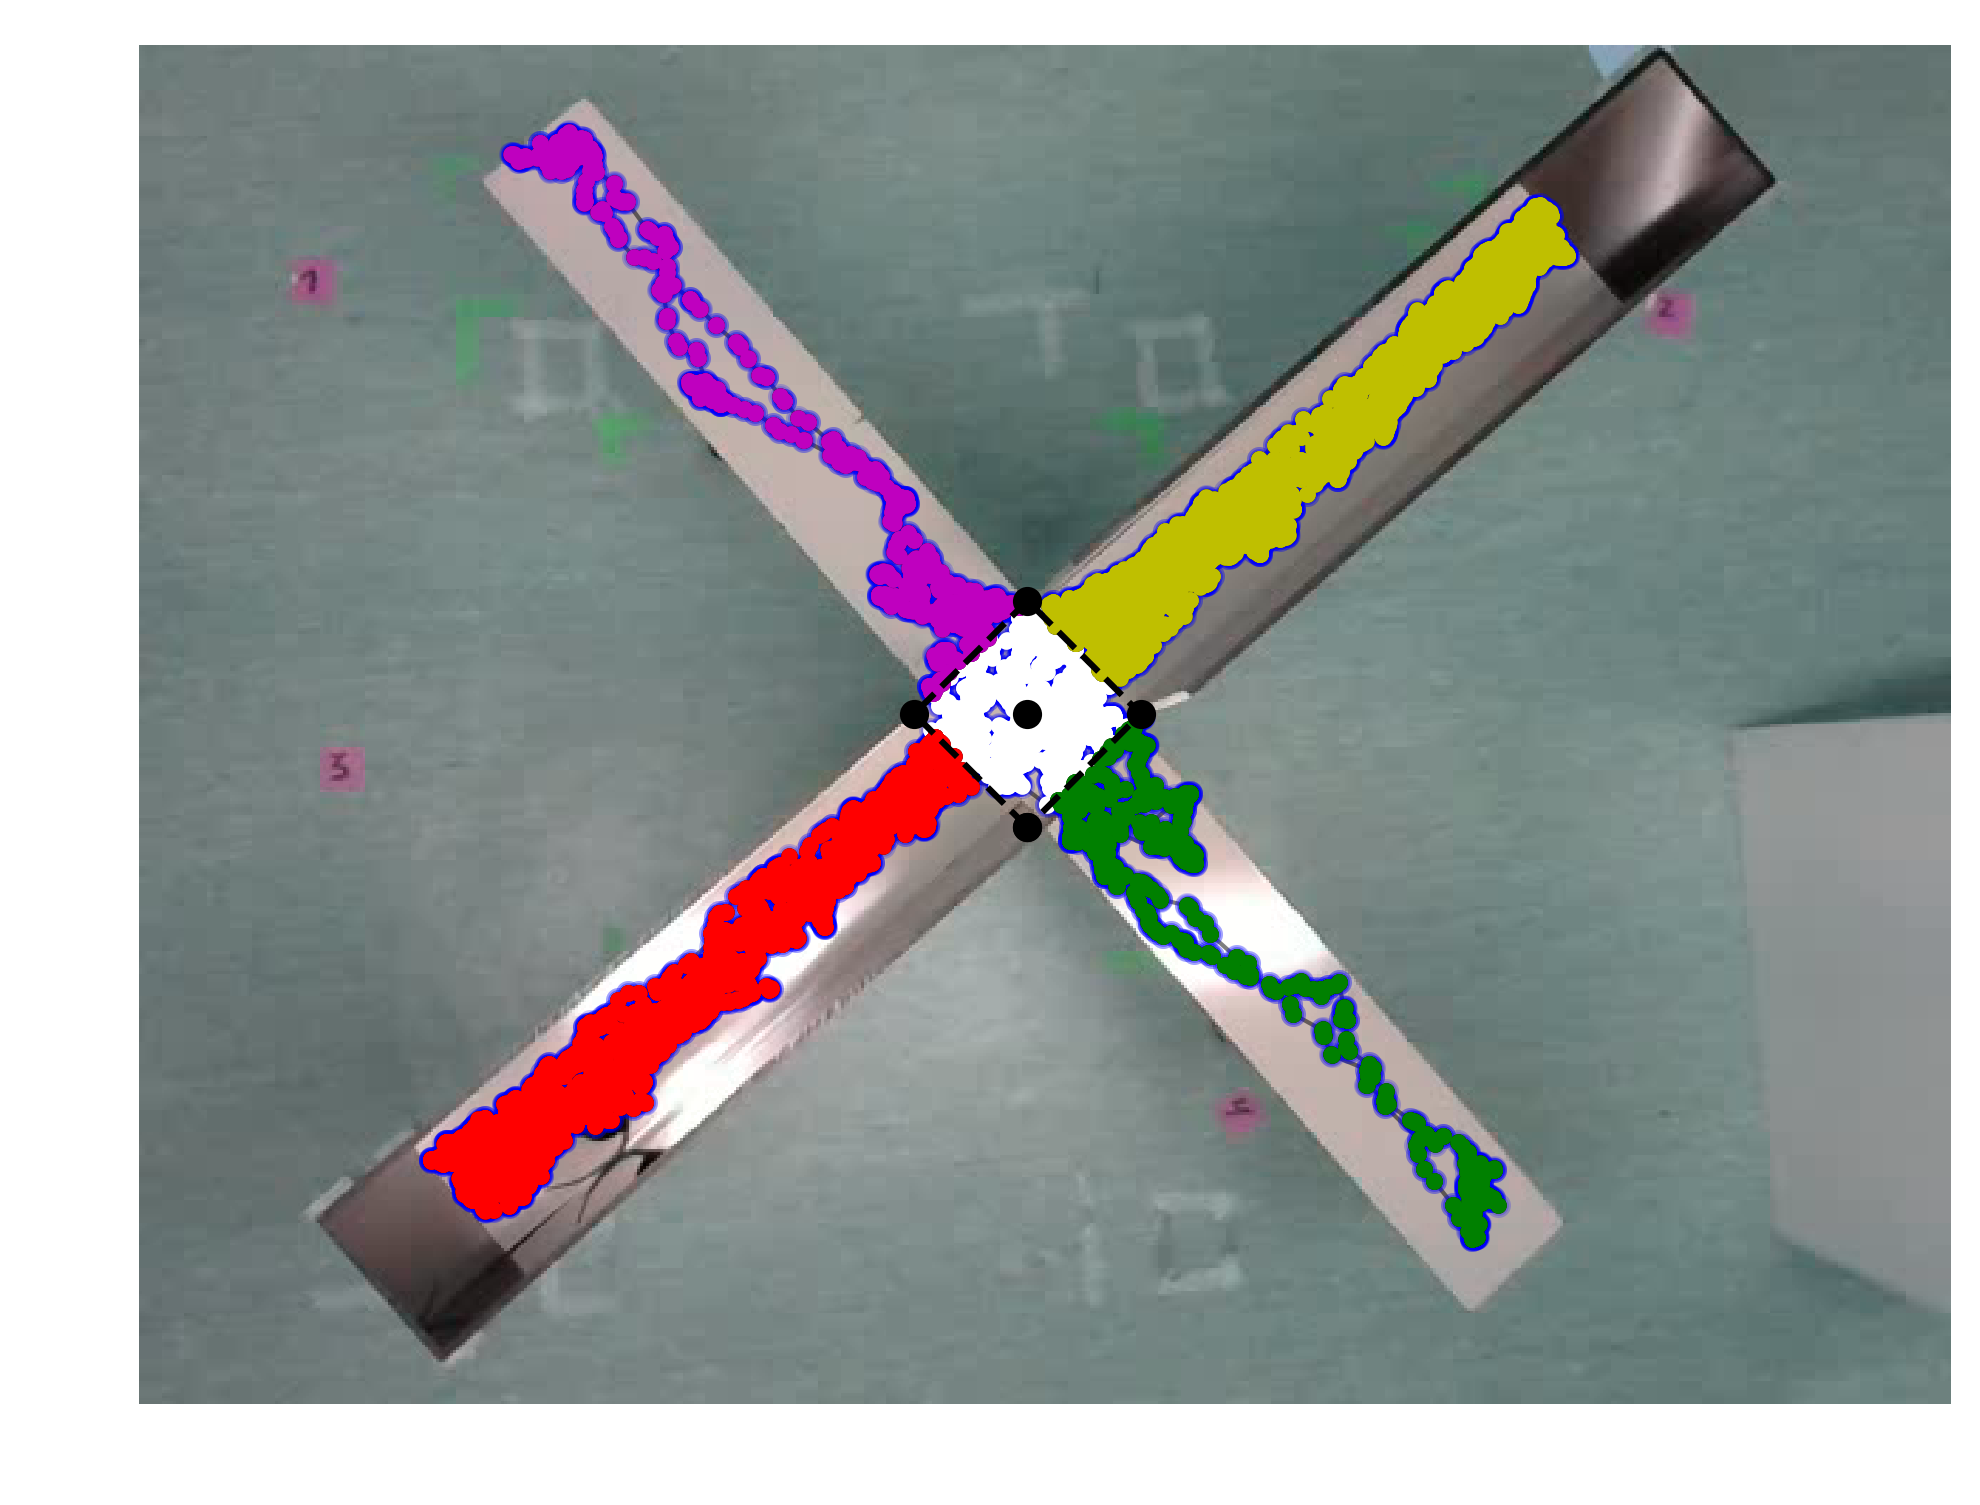

In [103]:
open_to_close_ratio(filename, '.avi');